In [265]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
from model.networks import Discriminator
import torch
import torchvision.transforms as T
import os
import argparse
from PIL import Image
import torch
import torchvision.transforms as T



In [266]:
def apply_gabor_filters(image, scales, orientations):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    responses = []

    for scale in scales:
        for orientation in orientations:
            # Apply Gabor filter
            gabor_kernel = cv2.getGaborKernel(
                (31, 31), # Size of the filter
                scale, # Standard deviation of the Gaussian envelope
                orientation,  # Orientation of the normal to the Gabor function
                10.0,  # Wavelength of the sinusoidal factor
                0.8,  # Spatial aspect ratio
                0,  # Phase offset
                ktype=cv2.CV_32F
            )
            gabor_response = cv2.filter2D(gray_image, cv2.CV_32F, gabor_kernel)
            responses.append(gabor_response)

    return responses

In [267]:
def compute_texturization_percentage(image, responses, visualize = False, threshold=0.5):
    # Normalize each response separately
    normalized_responses = [np.abs(response) / np.max(np.abs(response)) for response in responses]

    # Find the highest value for each pixel across all responses
    max_responses = np.max(np.stack(normalized_responses), axis=0)

    # Count the number of pixels above the threshold
    above_threshold_pixels = np.sum(max_responses > threshold)

    # Compute the percentage of heavily texturized pixels
    total_pixels = np.prod(max_responses.shape)
    percentage_texturized = (above_threshold_pixels / total_pixels) * 100
    if visualize:
        visualize_above_threshold_and_max_response(image, max_responses)

    
    return percentage_texturized, max_responses

In [268]:
def visualize_above_threshold_and_max_response(image, max_responses):
    fig, axes = plt.subplots(1, 1, figsize=(7, 3))

    # Max Response
    axes.imshow(max_responses)
    axes.set_title('Max Response')
    axes.axis('off')


    plt.tight_layout()
    plt.show()

In [269]:
def visualize_response_map(responses, scales, orientations):
    num_scales = len(scales)
    num_orientations = len(orientations)

    fig, axes = plt.subplots(num_scales, num_orientations, figsize=(12, 12))

    for i in range(num_scales):
        for j in range(num_orientations):
            index = i * num_orientations + j
            ax = axes[i, j] if num_scales > 1 else axes[j]

            response = responses[index]

            ax.imshow(response)
            ax.set_title(f'Scale: {scales[i]}, Orientation: {orientations[j]}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()


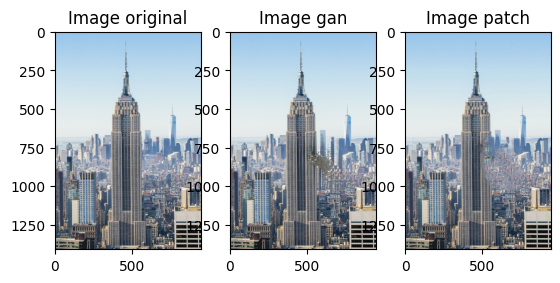

(1408, 944, 3) (1408, 944, 3) (1408, 944, 3)


In [270]:
image_GAN_path = 'examples/inpaint/empire_gan.png'
image_patch_path =  'examples/inpaint/empire_patch.png'
image_original_path =  'examples/inpaint/empire.jpg'

image_original = cv2.imread(image_original_path)
pixels_to_remove_x = 4
pixels_to_remove_y = 6
image_original = image_original[:-pixels_to_remove_y, :-pixels_to_remove_x]

image_GAN = cv2.imread(image_GAN_path)

#image_GAN = cv2.resize(image_GAN, (image_original.shape[1], image_original.shape[0]))
image_patch = cv2.imread(image_patch_path)
image_patch = image_patch[:-pixels_to_remove_y, :-pixels_to_remove_x]

image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)
image_GAN = cv2.cvtColor(image_GAN, cv2.COLOR_BGR2RGB)
image_patch = cv2.cvtColor(image_patch, cv2.COLOR_BGR2RGB)

plt.subplot(1, 3, 1)
plt.imshow(image_original)
plt.title('Image original')

plt.subplot(1, 3, 2)
plt.imshow(image_GAN)
plt.title('Image gan')

plt.subplot(1, 3, 3)
plt.imshow(image_patch)  # Use a suitable colormap
plt.title('Image patch')

plt.show()

print(image_original.shape, image_GAN.shape, image_patch.shape)

In [271]:
scales = [2]
orientations = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]


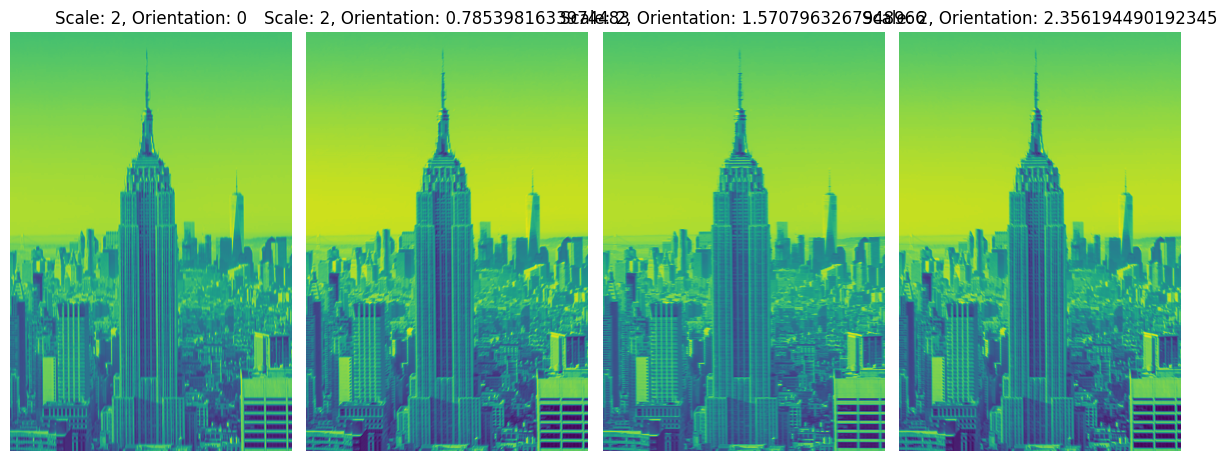

In [272]:
responses_original = apply_gabor_filters(image_original, scales, orientations)
responses_GAN = apply_gabor_filters(image_GAN, scales, orientations)
responses_patch = apply_gabor_filters(image_patch, scales, orientations)

visualize_response_map(responses_original, scales, orientations)

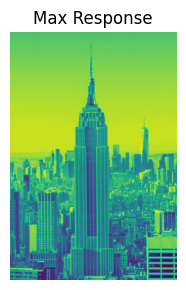

Texturization Score: 74.50013241525424


In [273]:
# Compute texturization score
score, max_response_original = compute_texturization_percentage(image_original, responses_original, True)
print(f'Texturization Score: {score}')

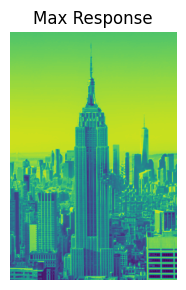

Texturization Score: 73.44013325789676


In [274]:
score, max_response_GAN = compute_texturization_percentage(image_GAN, responses_GAN, True)
print(f'Texturization Score: {score}')

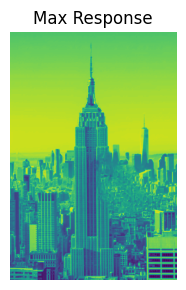

Texturization Score: 75.05146138289676


In [275]:
score, max_response_patch = compute_texturization_percentage(image_patch, responses_patch, True)
print(f'Texturization Score: {score}')

In [306]:
def test1_higher_pixel(responses_image1, responses_image2, image1, image2, name):
    mask = responses_image1 > responses_image2

    # Use the mask to select pixels from either image1 or image2
    selected_responses = np.where(mask[:, :, np.newaxis], image1, image2)

    # Display the image
    plt.imshow(selected_responses)
    plt.title('Selected Responses')
    plt.show()

    cv2.imwrite('./examples/inpaint/results/test1_higher_pixel_'+ name + '.png', cv2.cvtColor(selected_responses, cv2.COLOR_RGB2BGR))
    return selected_responses



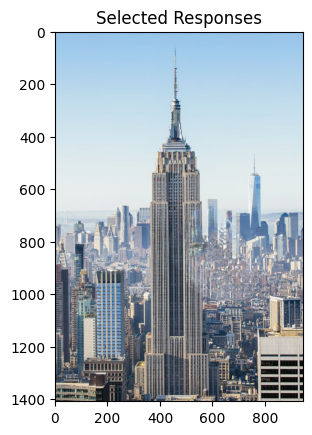

In [307]:
higher_pixel = test1_higher_pixel(max_response_GAN, max_response_patch, image_GAN, image_patch, "empire")

In [308]:
def test2_combination(responses_image1, responses_image2, image1, image2, name):
    # Compute normalized responses
    total_responses = responses_image1 + responses_image2
    normalized_responses1 = responses_image1 / total_responses
    normalized_responses2 = responses_image2 / total_responses

    # Combine images based on normalized responses
    selected_responses = (
        image1 * normalized_responses1[:, :, np.newaxis] +
        image2 * normalized_responses2[:, :, np.newaxis]
    )
    selected_responses = np.clip(selected_responses, 0, 255).astype(np.uint8)

    # Display the image
    plt.imshow(selected_responses)
    plt.title('Combined Image')
    plt.show()

    # Save the image
    cv2.imwrite('./examples/inpaint/results/test2_combination_'+ name + '.png', cv2.cvtColor(selected_responses, cv2.COLOR_RGB2BGR))
    return selected_responses


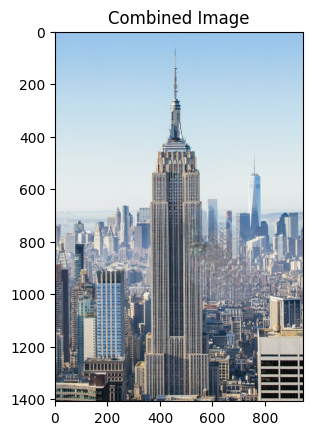

In [309]:
combination = test2_combination(max_response_GAN, max_response_patch, image_GAN, image_patch, "empire")

In [310]:
def test3_original_decides(responses_image_original, image1, image2, name):
    mask = responses_image_original > 0.5
    selected_responses = np.where(mask[:, :, np.newaxis], image2, image1)
     
    plt.imshow(selected_responses)
    plt.title('Original decides')
    plt.show()
    
    # Save the image
    cv2.imwrite('./examples/inpaint/results/test3_original_decides_'+ name + '.png', cv2.cvtColor(selected_responses, cv2.COLOR_RGB2BGR))
    return selected_responses

  


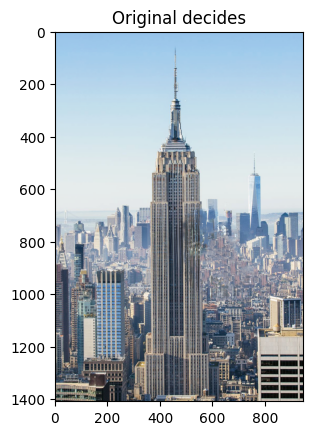

In [311]:
original_decides = test3_original_decides(max_response_original, image_GAN, image_patch, "empire")

In [312]:
def calculate_metrics(original_image, new_image):
    mse_noise = mean_squared_error(original_image, new_image)
    ssim_noise = ssim(original_image, new_image,
                   full=True,win_size=3)
    PSNR = peak_signal_noise_ratio(original_image, new_image) 
    
    print("MSE: " + str(mse_noise))
    print("SSIM: " + str(ssim_noise[0]))
    print("PSNR: " + str(PSNR))
    print("\n")
    

In [283]:
calculate_metrics(image_original, image_GAN)
calculate_metrics(image_original, image_patch)
calculate_metrics(image_original, higher_pixel)
calculate_metrics(image_original, combination)
calculate_metrics(image_original, original_decides)

MSE: 147.802119195798
SSIM: 0.961414991984115
PSNR: 26.433996998236967


MSE: 140.46539823887713
SSIM: 0.9535163151364103
PSNR: 26.655110060550044


MSE: 146.15803885986455
SSIM: 0.9560375196124331
PSNR: 26.482576538226432


MSE: 103.24201119711415
SSIM: 0.9619485570697726
PSNR: 27.99223904677394


MSE: 118.9686501869864
SSIM: 0.957938002674512
PSNR: 27.37647826740219




# RUN FOR ALL 

## GANS

In [320]:
def run_for_gans(image, mask, name, out_route = './examples/inpaint/results/gans/' , checkpoint = 'pretrained/states_tf_places2.pth' ):
    generator_state_dict = torch.load(checkpoint)['G']

    if 'stage1.conv1.conv.weight' in generator_state_dict.keys():
        from model.networks import Generator
    else:
        from model.networks_tf import Generator  

    use_cuda_if_available = True
    device = torch.device('cuda' if torch.cuda.is_available()
                          and use_cuda_if_available else 'cpu')

    # set up network
    generator = Generator(cnum_in=5, cnum=48, return_flow=False).to(device)

    generator_state_dict = torch.load(checkpoint)['G']
    generator.load_state_dict(generator_state_dict, strict=True)



    # prepare input
    image = T.ToTensor()(image)
    mask = T.ToTensor()(mask)
    _, h, w = image.shape
    grid = 8

    image = image[:3, :h//grid*grid, :w//grid*grid].unsqueeze(0)
    mask = mask[0:1, :h//grid*grid, :w//grid*grid].unsqueeze(0)

    print(f"Shape of image: {image.shape}")

    image = (image*2 - 1.).to(device)  # map image values to [-1, 1] range
    mask = (mask > 0.5).to(dtype=torch.float32,
                           device=device)  # 1.: masked 0.: unmasked

    image_masked = image * (1.-mask)  # mask image

    ones_x = torch.ones_like(image_masked)[:, 0:1, :, :]
    x = torch.cat([image_masked, ones_x, ones_x*mask],
                  dim=1)  # concatenate channels

    with torch.inference_mode():
        x_stage1, x_stage2 = generator(x, mask)

    # complete image
    image_inpainted = image * (1.-mask) + x_stage2 * mask

    # save inpainted image
    img_out = ((image_inpainted[0].permute(1, 2, 0) + 1)*127.5)
    img_out = img_out.to(device='cpu', dtype=torch.uint8)
    img_out = Image.fromarray(img_out.numpy())
    img_out.save(out_route + name)

      # complete image
    image_inpainted = image * (1.-mask) + x_stage1 * mask

    # save inpainted image
    img_out = ((image_inpainted[0].permute(1, 2, 0) + 1)*127.5)
    img_out = img_out.to(device='cpu', dtype=torch.uint8)
    img_out = Image.fromarray(img_out.numpy())
    img_out.save(out_route+ "stage1/" + name)


In [321]:
def create_gan_inpaints():
    original_path = './examples/inpaint/testImages/'
    mask_path = './examples/inpaint/masks/'
    
    image_files = [f for f in os.listdir(original_path) if f.endswith(('.png', '.jpg', '.jpeg'))]


    # Iterate through each image file
    for image_file in image_files:
        print(image_file)
        name = image_file.split(".")[0]
        
        mask_name = name + "_mask.png"
        mask_file = mask_path + mask_name
        image_file = original_path  + image_file
        image = Image.open(image_file)
        mask = Image.open(mask_file)
        run_for_gans(image, mask, name +".png")




In [322]:
create_gan_inpaints()

fence.png
Shape of image: torch.Size([1, 3, 512, 512])
toronto.png
Shape of image: torch.Size([1, 3, 344, 616])
cartagena2.png
Shape of image: torch.Size([1, 3, 512, 512])
forest.png
Shape of image: torch.Size([1, 3, 368, 640])
night.png
Shape of image: torch.Size([1, 3, 1000, 664])
cartagena.png
Shape of image: torch.Size([1, 3, 512, 768])
nature.png
Shape of image: torch.Size([1, 3, 504, 1000])


## Run for patch

## Run weighted join

In [315]:
def get_images(path_original, path_patch, path_gan):
    
    image_original = cv2.imread(path_original)
    pixels_to_remove_x = 0
    pixels_to_remove_y = 0
    image_original = image_original[:-pixels_to_remove_y, :-pixels_to_remove_x]
    
    image_GAN = cv2.imread(path_gan)
    
    #image_GAN = cv2.resize(image_GAN, (image_original.shape[1], image_original.shape[0]))
    image_patch = cv2.imread(path_patch)
    image_patch = image_patch[:-pixels_to_remove_y, :-pixels_to_remove_x]
    
    image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)
    image_GAN = cv2.cvtColor(image_GAN, cv2.COLOR_BGR2RGB)
    image_patch = cv2.cvtColor(image_patch, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 3, 1)
    plt.imshow(image_original)
    plt.title('Image original')
    
    plt.subplot(1, 3, 2)
    plt.imshow(image_GAN)
    plt.title('Image gan')
    
    plt.subplot(1, 3, 3)
    plt.imshow(image_patch)  # Use a suitable colormap
    plt.title('Image patch')
    
    plt.show()
    
    print(image_original.shape, image_GAN.shape, image_patch.shape)
    return image_original, image_GAN, image_patch
    

In [316]:
original_path = './examples/inpaint/testImages/'
gan_path = './examples/inpaint/results/gans/'
patch_path = './examples/inpaint/results_mpnn/'

mask_path = './examples/inpaint/masks/'

# List all files in the folder
images_original = [f for f in os.listdir(original_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
masks  = [f for f in os.listdir(mask_path) if f.endswith(('.png', '.jpg', '.jpeg'))]


# Iterate through each image file
for image_original in images_original:
    name = image_original.split(".")[0]
    original, gan, patch = get_images(original_path+image_original, patch_path+image_original, gan_path+image_original)
    responses_original = apply_gabor_filters(original, scales, orientations)
    responses_GAN = apply_gabor_filters(gan, scales, orientations)
    responses_patch = apply_gabor_filters(patch, scales, orientations)
    score, max_response_patch = compute_texturization_percentage(patch, responses_patch)
    score, max_response_GAN = compute_texturization_percentage(gan, responses_GAN)
    score, max_response_original = compute_texturization_percentage(original, responses_original)

    test1_higher_pixel(max_response_patch, max_response_GAN, patch, gan, name)
    test2_combination(max_response_patch, max_response_GAN, patch, gan, name)
    test3_original_decides(max_response_original, gan, patch, name)



error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
